In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-11-06 23:06:14.680891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 

In [3]:
# Define domain and time period
start_lat = 5 
end_lat = 10
start_lon = -10
end_lon = 0
start_year = '2010'
start_month = '07'
end_year = '2010'
end_month = '07'
start_day = '01'
end_day = '31'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)

cores = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*96)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in input data- TIR and historical core data at t<to
#core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
#ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
#cores = ds['msg_cores'].values# uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
#tir = ds['msg_Tir'].values/10000 # uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR          
#time_core = ds['time']# (core_filename[-15:-3])


In [7]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,30,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        if y==1:
            for m in range(int(start_month),10,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
                y=y+1
                month=[]
            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)    
                for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

2784


In [8]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010000.nc
0
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010015.nc
1
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010030.nc
2
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010045.nc
3
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010100.nc
4
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010115.nc
5
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010130.nc
6
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010145.nc
7
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010200.nc
8
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010215.nc
9
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010230.nc
10
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010245.nc
11
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010300.nc
12
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010315.nc
13
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010330.nc
14
/prj/

/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020645.nc
123
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020700.nc
124
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020715.nc
125
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020730.nc
126
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020745.nc
127
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020800.nc
128
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020815.nc
129
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020830.nc
130
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020845.nc
131
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020900.nc
132
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020915.nc
133
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020930.nc
134
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020945.nc
135
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021000.nc
136
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_

245
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031330.nc
246
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031345.nc
247
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031400.nc
248
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031415.nc
249
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031430.nc
250
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031445.nc
251
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031500.nc
252
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031515.nc
253
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031530.nc
254
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031545.nc
255
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031600.nc
256
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031615.nc
257
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031630.nc
258
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031645.nc
259
/prj/nflics/hist_cores/2010/07/03/Hist_cores

367
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042000.nc
368
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042015.nc
369
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042030.nc
370
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042045.nc
371
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042100.nc
372
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042115.nc
373
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042130.nc
374
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042145.nc
375
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042200.nc
376
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042215.nc
377
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042230.nc
378
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042245.nc
379
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042300.nc
380
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042315.nc
381
/prj/nflics/hist_cores/2010/07/04/Hist_cores

/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060230.nc
490
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060245.nc
491
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060300.nc
492
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060315.nc
493
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060330.nc
494
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060345.nc
495
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060400.nc
496
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060415.nc
497
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060430.nc
498
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060445.nc
499
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060500.nc
500
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060515.nc
501
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060530.nc
502
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060545.nc
503
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_

/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070900.nc
612
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070915.nc
613
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070930.nc
614
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070945.nc
615
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071000.nc
616
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071015.nc
617
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071030.nc
618
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071045.nc
619
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071100.nc
620
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071115.nc
621
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071130.nc
622
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071145.nc
623
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071200.nc
624
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071215.nc
625
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_

/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081515.nc
733
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081530.nc
734
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081545.nc
735
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081600.nc
736
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081615.nc
737
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081630.nc
738
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081645.nc
739
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081700.nc
740
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081715.nc
741
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081730.nc
742
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081745.nc
743
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081800.nc
744
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081815.nc
745
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081830.nc
746
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_

/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092145.nc
855
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092200.nc
856
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092215.nc
857
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092230.nc
858
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092245.nc
859
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092300.nc
860
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092315.nc
861
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092330.nc
862
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092345.nc
863
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100000.nc
864
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100015.nc
865
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100030.nc
866
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100045.nc
867
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100100.nc
868
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_

975
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110400.nc
976
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110415.nc
977
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110430.nc
978
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110445.nc
979
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110500.nc
980
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110515.nc
981
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110530.nc
982
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110545.nc
983
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110600.nc
984
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110615.nc
985
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110630.nc
986
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110645.nc
987
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110700.nc
988
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110715.nc
989
/prj/nflics/hist_cores/2010/07/11/Hist_cores

/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121000.nc
1096
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121015.nc
1097
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121030.nc
1098
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121045.nc
1099
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121100.nc
1100
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121115.nc
1101
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121130.nc
1102
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121145.nc
1103
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121200.nc
1104
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121215.nc
1105
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121230.nc
1106
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121245.nc
1107
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121300.nc
1108
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121315.nc
1109
/prj/nflics/hist_cores/2010/07/12/

/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131545.nc
1215
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131600.nc
1216
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131615.nc
1217
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131630.nc
1218
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131645.nc
1219
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131700.nc
1220
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131715.nc
1221
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131730.nc
1222
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131745.nc
1223
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131800.nc
1224
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131815.nc
1225
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131830.nc
1226
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131845.nc
1227
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131900.nc
1228
/prj/nflics/hist_cores/2010/07/13/

/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142145.nc
1335
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142200.nc
1336
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142215.nc
1337
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142230.nc
1338
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142245.nc
1339
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142300.nc
1340
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142315.nc
1341
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142330.nc
1342
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142345.nc
1343
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150000.nc
1344
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150015.nc
1345
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150030.nc
1346
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150045.nc
1347
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150100.nc
1348
/prj/nflics/hist_cores/2010/07/15/

/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160330.nc
1454
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160345.nc
1455
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160400.nc
1456
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160415.nc
1457
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160430.nc
1458
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160445.nc
1459
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160500.nc
1460
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160515.nc
1461
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160530.nc
1462
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160545.nc
1463
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160600.nc
1464
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160615.nc
1465
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160630.nc
1466
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160645.nc
1467
/prj/nflics/hist_cores/2010/07/16/

/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170930.nc
1574
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170945.nc
1575
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171000.nc
1576
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171015.nc
1577
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171030.nc
1578
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171045.nc
1579
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171100.nc
1580
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171115.nc
1581
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171130.nc
1582
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171145.nc
1583
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171200.nc
1584
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171215.nc
1585
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171230.nc
1586
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171245.nc
1587
/prj/nflics/hist_cores/2010/07/17/

/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181515.nc
1693
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181530.nc
1694
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181545.nc
1695
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181600.nc
1696
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181615.nc
1697
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181630.nc
1698
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181645.nc
1699
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181700.nc
1700
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181715.nc
1701
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181730.nc
1702
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181745.nc
1703
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181800.nc
1704
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181815.nc
1705
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181830.nc
1706
/prj/nflics/hist_cores/2010/07/18/

/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192100.nc
1812
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192115.nc
1813
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192130.nc
1814
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192145.nc
1815
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192200.nc
1816
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192215.nc
1817
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192230.nc
1818
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192245.nc
1819
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192300.nc
1820
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192315.nc
1821
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192330.nc
1822
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192345.nc
1823
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200000.nc
1824
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200015.nc
1825
/prj/nflics/hist_cores/2010/07/20/

1931
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210300.nc
1932
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210315.nc
1933
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210330.nc
1934
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210345.nc
1935
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210400.nc
1936
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210415.nc
1937
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210430.nc
1938
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210445.nc
1939
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210500.nc
1940
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210515.nc
1941
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210530.nc
1942
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210545.nc
1943
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210600.nc
1944
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210615.nc
1945
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220845.nc
2051
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220900.nc
2052
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220915.nc
2053
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220930.nc
2054
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220945.nc
2055
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221000.nc
2056
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221015.nc
2057
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221030.nc
2058
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221045.nc
2059
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221100.nc
2060
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221115.nc
2061
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221130.nc
2062
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221145.nc
2063
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221200.nc
2064
/prj/nflics/hist_cores/2010/07/22/

2171
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231500.nc
2172
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231515.nc
2173
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231530.nc
2174
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231545.nc
2175
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231600.nc
2176
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231615.nc
2177
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231630.nc
2178
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231645.nc
2179
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231700.nc
2180
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231715.nc
2181
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231730.nc
2182
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231745.nc
2183
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231800.nc
2184
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231815.nc
2185
/prj/nflics/hist_cores/2010/0

2290
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242045.nc
2291
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242100.nc
2292
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242115.nc
2293
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242130.nc
2294
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242145.nc
2295
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242200.nc
2296
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242215.nc
2297
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242230.nc
2298
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242245.nc
2299
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242300.nc
2300
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242315.nc
2301
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242330.nc
2302
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242345.nc
2303
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007250000.nc
2304
/prj/nflics/hist_cores/2010/0

2411
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260300.nc
2412
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260315.nc
2413
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260330.nc
2414
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260345.nc
2415
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260400.nc
2416
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260415.nc
2417
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260430.nc
2418
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260445.nc
2419
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260500.nc
2420
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260515.nc
2421
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260530.nc
2422
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260545.nc
2423
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260600.nc
2424
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260615.nc
2425
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270900.nc
2532
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270915.nc
2533
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270930.nc
2534
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270945.nc
2535
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271000.nc
2536
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271015.nc
2537
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271030.nc
2538
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271045.nc
2539
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271100.nc
2540
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271115.nc
2541
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271130.nc
2542
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271145.nc
2543
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271200.nc
2544
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271215.nc
2545
/prj/nflics/hist_cores/2010/07/27/

/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281445.nc
2651
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281500.nc
2652
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281515.nc
2653
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281530.nc
2654
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281545.nc
2655
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281600.nc
2656
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281615.nc
2657
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281630.nc
2658
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281645.nc
2659
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281700.nc
2660
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281715.nc
2661
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281730.nc
2662
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281745.nc
2663
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281800.nc
2664
/prj/nflics/hist_cores/2010/07/28/

2771
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292100.nc
2772
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292115.nc
2773
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292130.nc
2774
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292145.nc
2775
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292200.nc
2776
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292215.nc
2777
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292230.nc
2778
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292245.nc
2779
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292300.nc
2780
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292315.nc
2781
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292330.nc
2782
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292345.nc
2783


In [9]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


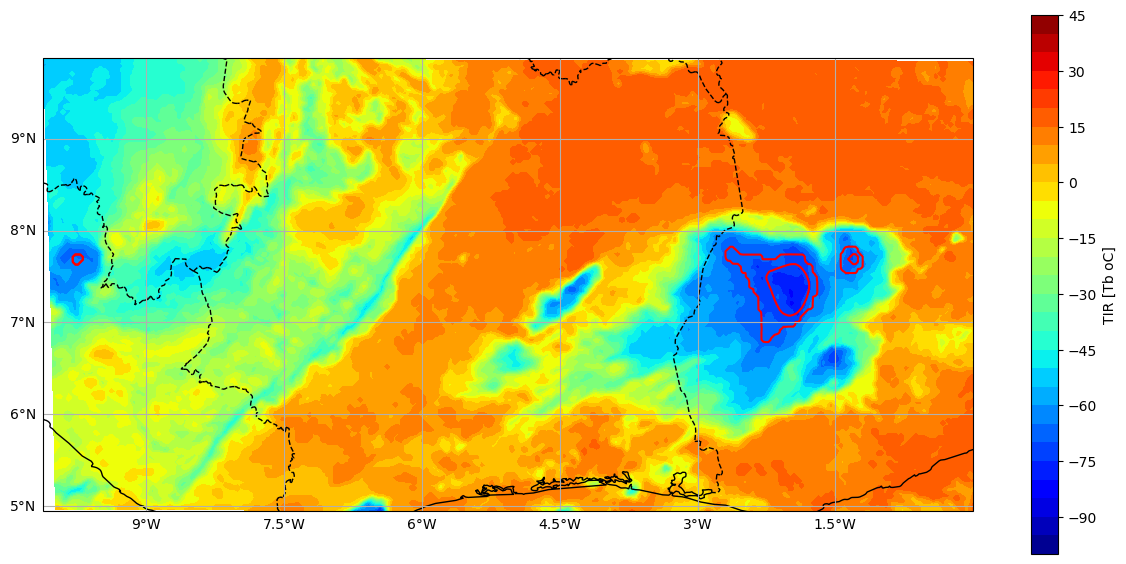

In [10]:
day = 6#24*1
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')

#

In [11]:
# input data
# starting at 
t0=3*4
a=51
b=111
cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
cores_t_0 = cores[t0:-t0, a:,b:]
tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
tir_t_0 = tir[t0:-t0, a:,b:]


#target data
cores_t_plus_xhr = cores[t0*2:, a:,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
#print(np.unique(cores_t_plus_xhr))


In [12]:
print(cores_t_0.shape)
print(cores_t_plus_xhr.shape)
print(len(lat[51:,1]))
print(len(lat[1,111:]))

#179-128
#367-256

(2952, 128, 256)
(2952, 128, 256)
128
256


In [13]:
# save variables 
#with open('WA_subdomain_cores.pkl', 'wb') as file: 
         # pickle.dump([cores_t_minus_xhr,cores_t_0,tir_t_minus_xhr,tir_t_0,cores_t_plus_xhr], file) 

In [14]:
# Define input shape
num_frames= 24  # hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 1 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [15]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=16, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128, 256,   0         
                             1)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 128, 256, 1  27264     
                             6)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 128, 256, 1  64       
 ormalization)               6)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 128, 256, 8  6944      
                             )                                   
                                                                 
 batch_normalization_1 (Batc  (None, None, 128, 256, 8  32   

In [17]:
num_frames= 24  # hours
batch_size= len(cores_t_0[:,0,0])/num_frames  # days 720
num_of_batches = round(len(cores_t_0[:,0,0])/batch_size)
x_train= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))

x_val= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))

                  
                  
for i in range(0,num_of_batches,1): #i=batch number
    #x_batch= cores_t_0[i:i+batch_size,:,:]
    #y_batch= cores_t_plus_xhr[i:i+batch_size,:,:]
    #for j in range(0, num_of_batches, batch_size,num_frames):
     #   f=1    
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
        
x_train = x_train/np.max(x_train)
        
#x_val = 
#y_val[i+500] = create_shifted_frames(val_dataset)
for i in range(0,num_of_batches,1): #i=batch number
    #x_batch= cores_t_0[i:i+batch_size,:,:]
    #y_batch= cores_t_plus_xhr[i:i+batch_size,:,:]
    #for j in range(0, num_of_batches, batch_size,num_frames):
     #   f=1    
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
 

#x = data[:, 0 : data.shape[1] - 1, :, :]
#y = data[:, 1 : data.shape[1], :, :]
#batch_size, num_frames, width, height, channels)
#Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
#Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)

In [18]:
print(x_train.shape)

(24, 24, 128, 256, 1)


In [19]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
1/1 [==============================] - 77s 77s/step - loss: 0.6933 - val_loss: 0.6963 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - 73s 73s/step - loss: 0.7034 - val_loss: 0.6940 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - 73s 73s/step - loss: 0.6850 - val_loss: 0.6919 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - 73s 73s/step - loss: 0.6790 - val_loss: 0.6898 - lr: 0.0010
Epoch 5/20
1/1 [==============================] - 73s 73s/step - loss: 0.6725 - val_loss: 0.6878 - lr: 0.0010
Epoch 6/20
1/1 [==============================] - 73s 73s/step - loss: 0.6633 - val_loss: 0.6852 - lr: 0.0010
Epoch 7/20
1/1 [==============================] - 73s 73s/step - loss: 0.6527 - val_loss: 0.6830 - lr: 0.0010
Epoch 8/20
1/1 [==============================] - 73s 73s/step - loss: 0.6405 - val_loss: 0.6800 - lr: 0.0010
Epoch 9/20
1/1 [==============================] - 73s 73s/step - loss: 0.6256 - val_loss: 0.6770 - lr: 0.0010
Epoch 10/2

In [20]:
example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
print(example.shape)

(24, 128, 256, 1)


In [21]:
# Select a random example from the validation dataset.
#xample = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = x_val[0,:,:,:,:]
original_frames = y_val[0,:,:,:,:]

# Predict a new set of 10 frames.
for _ in range(2):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)


1/1 [==============================] - 1s 745ms/step


In [22]:
print(frames.shape)

(26, 128, 256, 1)


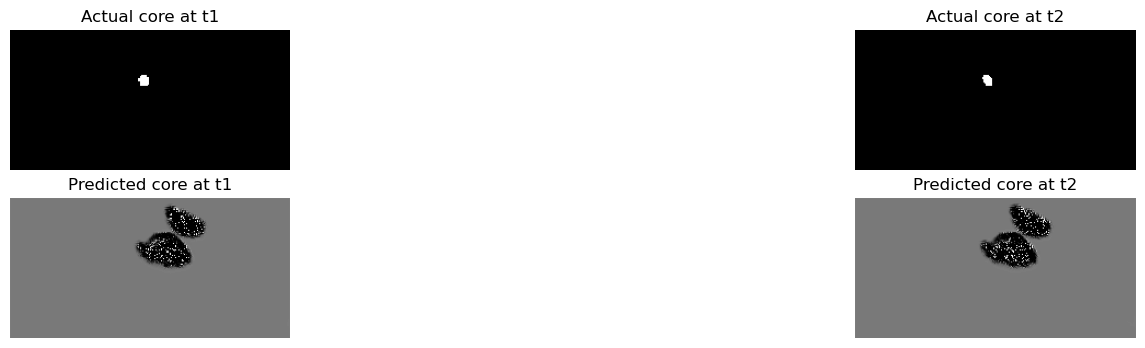

In [23]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 2, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Actual core at t{idx+1}")
#    ax.set_title(f"Frame {idx + 24}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[24:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted core at t{idx+1}")
    ax.axis("off")

# Display the figure.
plt.show()